# Setup

In [ ]:
!pip install catboost
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 9.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.5/210.5 KB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 12.0 MB/s eta 0:00:00


# 3.GradientBoostingClassifier

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')
submit = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')

train_x = train_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP', 'Y_Class','Y_Quality'])
train_y = train_df['Y_Class']
test_x = test_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])   

# 1) qualitative to quantitative
qual_col = ['LINE', 'PRODUCT_CODE']
for i in qual_col:
    le = LabelEncoder()    # TRY one-hot encoding 
    le = le.fit(train_x[i])
    train_x[i] = le.transform(train_x[i])
    for label in np.unique(test_x[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test_x[i] = le.transform(test_x[i]) 

# 2) Missing Values 
train_x = train_x.fillna(0)
test_x = test_x.fillna(0)

# 3) scaling: only `X_???` values (continuous)
Xs = train_x.select_dtypes(include=float).iloc[:,1:].columns.tolist()
scaler = MinMaxScaler().fit(train_x.loc[:, Xs])
train_x.loc[:, Xs] = scaler.transform(train_x.loc[:, Xs])
test_x.loc[:, Xs] = scaler.transform(test_x.loc[:, Xs])


# train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, 
                                                    random_state=37, test_size=0.3)


from sklearn.ensemble import GradientBoostingClassifier
# GBC =  GradientBoostingClassifier(random_state=37).fit(train_x, train_y)
# preds = GBC.predict(test_x)
# sns.countplot(x=preds);
# preds

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')
submit['Y_Class'] = preds

submit.to_csv('GBC_MMs_trainx-smartFactorySubmission.csv', index=False)
# sns.countplot(x=preds);

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

def objective(trial, X, y, cv, scoring):
  """
  An objective function to tune hyperparameters of Gradient Boosting Classifier.
  Args:
    trial: an Optuna trial
    X: DataFrame object, features
    y: Series object, Labels
    cv: k folds to cross-validate
    scoring: String, evaluation metric
  Return:
    Mean test accuracy
  """

  params = {
    "n_estimators": trial.suggest_int("n_estimators", 100, 5000, step = 100),
    "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3, log = True),
    "max_depth": trial.suggest_int("max_depth", 3, 9),
    "subsample": trial.suggest_float("subsample", 0.5, 0.9, step = 0.1),
    "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt", "log2"]),
    "random_state": 37,
    }
  # Perform cross validation
  gb_class = GradientBoostingClassifier(**params)

  # Compute scores
  scores = cross_validate(gb_class, X, y, cv = cv, scoring = scoring, n_jobs = -1)
  accuracy = scores["test_score"].mean()

  return accuracy

In [ ]:

study = optuna.create_study(direction = "maximize")

kf = KFold(n_splits = 5, shuffle = True, random_state = 37)

func = lambda trial: objective(trial, train_x, train_y, cv = kf, scoring = "accuracy")

study.optimize(func, n_trials = 30)
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")


[I 2023-02-26 05:16:54,586] A new study created in memory with name: no-name-ebd42908-1b5f-4809-88ea-9d8a58a133ef
[I 2023-02-26 06:12:00,648] Trial 0 finished with value: 0.7506582633053223 and parameters: {'n_estimators': 3600, 'learning_rate': 0.00021479973315201132, 'max_depth': 9, 'subsample': 0.8, 'max_features': 'auto'}. Best is trial 0 with value: 0.7506582633053223.
[I 2023-02-26 06:12:43,290] Trial 1 finished with value: 0.8026610644257703 and parameters: {'n_estimators': 1500, 'learning_rate': 0.029761872801184145, 'max_depth': 8, 'subsample': 0.6, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8026610644257703.
[I 2023-02-26 06:12:49,179] Trial 2 finished with value: 0.6854621848739496 and parameters: {'n_estimators': 600, 'learning_rate': 0.0006573138814954677, 'max_depth': 3, 'subsample': 0.9, 'max_features': 'log2'}. Best is trial 1 with value: 0.8026610644257703.
[I 2023-02-26 06:12:50,600] Trial 3 finished with value: 0.7491036414565826 and parameters: {'n_estim

KeyboardInterrupt: ignored

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,

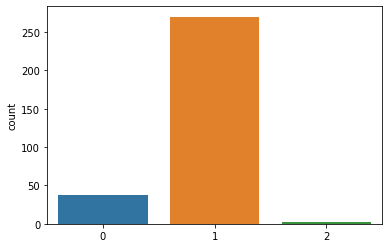

In [ ]:
import imblearn

# Trial 8 finished with value: 0.7976750700280112 and 
# param = {'n_estimators': 2500, 'learning_rate': 0.24437231062646464, 'max_depth': 7, 'subsample': 0.9, 'max_features': 'sqrt'}

# value: 0.7926050420168067 
param= {'n_estimators': 1400, 'learning_rate': 0.007793231258605556, 'max_depth': 6, 'subsample': 0.8, 'max_features': 'sqrt'}

GBC =  GradientBoostingClassifier(random_state=37, **param,                              
                                  ).fit(train_x, train_y)
preds = GBC.predict(test_x)
sns.countplot(x=preds);
preds

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,

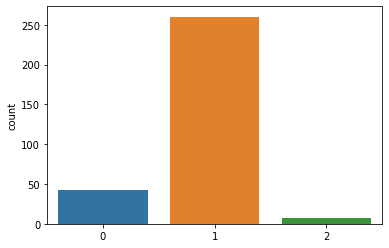

In [ ]:
# Best is trial 0 with value: 0.8026750700280111.
params= {'n_estimators': 4700, 'learning_rate': 0.007080906403563565, 'max_depth': 4, 'subsample': 0.8, 'max_features': 'sqrt'}

GBC =  GradientBoostingClassifier(random_state=37,
                                  **params,                              
                                  ).fit(train_x, train_y)
preds = GBC.predict(test_x)
sns.countplot(x=preds);
preds

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')
submit['Y_Class'] = preds

submit.to_csv('GBCoptuna-smartFactorySubmission.csv', index=False)

In [ ]:
def objective(trial):
    model = CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred, average='macro')
     
# hyper-parameter tuning with OPTUNA  
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=37)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=10)  

In [ ]:
print("Number of trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ",trial.params)

model = CatBoostClassifier(**trial.params, verbose=False, random_state = 37)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [ ]:
params=  {'iterations': 857, 'learning_rate': 0.07097207730593516, 'depth': 8, 'l2_leaf_reg': 0.00012090525126196811, 'bootstrap_type': 'Bayesian', 'random_strength': 5.359110894800412, 'bagging_temperature': 0.7137022569955509, 'od_type': 'IncToDec', 'od_wait': 42}
a = CatBoostClassifier(**params, verbose=False, random_state=37)
a.fit(X_train, y_train)


In [ ]:
y_pred1 = a.predict(X_test) 
print(classification_report(y_pred1, y_test))

              precision    recall  f1-score   support

           0       0.38      0.67      0.48        12
           1       0.97      0.79      0.87       160
           2       0.29      1.00      0.44         8

    accuracy                           0.79       180
   macro avg       0.55      0.82      0.60       180
weighted avg       0.90      0.79      0.83       180



In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.38      0.67      0.48        12
           1       0.97      0.79      0.87       160
           2       0.29      1.00      0.44         8

    accuracy                           0.79       180
   macro avg       0.55      0.82      0.60       180
weighted avg       0.90      0.79      0.83       180



In [ ]:
preds = a.predict(test_x)
preds.reshape([1,310])

array([[1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 

# 4.Ensemble
- 35~42

In [ ]:
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

models = [
   
    ('gb', GradientBoostingClassifier(random_state=37)),
    ('catB', CatBoostClassifier( 
    **params, verbose=False, random_state=37
)),
   
]

In [ ]:
vote = VotingClassifier(models, voting='soft', weights=[3,1]).fit(train_x, train_y)   

# preds = vote.predict_proba(test_x).reshape([1,310])
preds 

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 2, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,

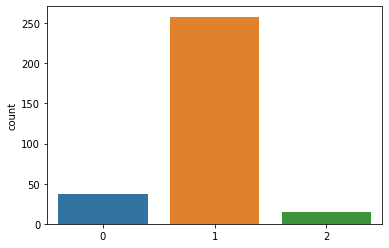

In [ ]:
preds = vote.predict(test_x)
preds
sns.countplot(x=preds);

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')
submit['Y_Class'] = preds

submit.to_csv('voting.catB_GBC.w3:1-smartFactorySubmission.csv', index=False)


In [ ]:
#   Params:  {'iterations': 848, 'learning_rate': 0.030969090455030726, 'depth': 8, 'l2_leaf_reg': 6.761650264581644e-08, 'bootstrap_type': 'Bayesian', 'random_strength': 5.097812627692342e-07, 'bagging_temperature': 7.206905770161392, 'od_type': 'IncToDec', 'od_wait': 49}

model = CatBoostClassifier( 
    iterations= 960, 
                                       learning_rate= 0.0022686226693627966,
                                       depth= 4, 
                                       l2_leaf_reg= 0.00025235896782569236, 
                                       bootstrap_type= 'Bayesian', 
                                       random_strength= 0.07344055855215284, 
                                       bagging_temperature= 0.5154099595769013, 
                                       od_type= 'IncToDec', 
                                       od_wait=34)


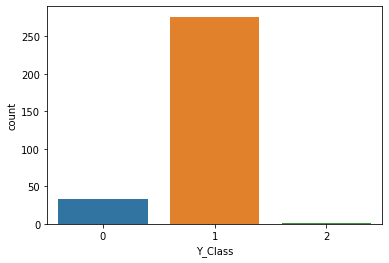

In [ ]:
# b = pd.read_csv('catB_noSMOTE-smartFactorySubmission.csv')
# sns.countplot(x = b['Y_Class']);

In [ ]:
import pickle
pickle.dump(model, open("catboost_model.pkl", "wb"))
     

optuna.visualization.plot_optimization_history(study)
     

optuna.visualization.plot_parallel_coordinate(study)
     

# 각 파라미터들의 상관관계
optuna.visualization.plot_contour(
    study,
    params=[
        "iterations",
        "learning_rate",
        "depth",
        "l2_leaf_reg",
        "bootstrap_type",
        "random_strength",
        "bagging_temperature",
        "od_type",
        "od_wait"
        ],
)

[W 2023-02-25 16:04:26,811] Param bootstrap_type unique value length is less than 2.
[W 2023-02-25 16:04:26,813] Param bootstrap_type unique value length is less than 2.
[W 2023-02-25 16:04:26,815] Param bootstrap_type unique value length is less than 2.
[W 2023-02-25 16:04:26,816] Param bootstrap_type unique value length is less than 2.
[W 2023-02-25 16:04:26,817] Param bootstrap_type unique value length is less than 2.
[W 2023-02-25 16:04:26,819] Param bootstrap_type unique value length is less than 2.
[W 2023-02-25 16:04:26,820] Param bootstrap_type unique value length is less than 2.
[W 2023-02-25 16:04:26,821] Param bootstrap_type unique value length is less than 2.
[W 2023-02-25 16:04:26,822] Param bootstrap_type unique value length is less than 2.
[W 2023-02-25 16:04:26,824] Param bootstrap_type unique value length is less than 2.
[W 2023-02-25 16:04:26,826] Param bootstrap_type unique value length is less than 2.
[W 2023-02-25 16:04:26,827] Param bootstrap_type unique value len

In [ ]:
# 하이퍼파라미터 중요도
optuna.visualization.plot_param_importances(study)

# 4.Submit

# THE END